In [1]:
import numpy as np
from matplotlib import pyplot as plt, ticker as mticker
from scipy.sparse import csr_matrix
import matplotlib as mpl
from scipy.integrate import quad
import numba
from scipy.integrate import solve_ivp

sys.path.append('../Numerical_methods')
from matrix_calculator import A_matrix
from scheme_calculator import forward_backward, central
from bachelor_funcs import get_first_dev
from ODE_schemes import A_matrix_regular

# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 14}
mpl.rc('font', **font)

In [2]:
N = 4001
x_i = 0.005
x_f = 100
x = np.linspace(x_i, x_f, N)
Δx = x[1] - x[0]
ΔT = 1
print(Δx)

A = A_matrix_regular(N, 3, 1) / Δx

0.02499875


In [3]:
# Inital surface density:
def Σ_initial(r, γ = 1):
    return (3 * np.pi * r**γ)**(-1) * np.exp(-r**(2 - γ))
C = 1 / quad(Σ_initial, x_i, x_f)[0]


# Normalized initial surface density
def Σ_initial_norm(r, γ = 1):
    return C * Σ_initial(r, γ)

In [4]:
# Analytical soltuion:
def Σ(r, T, γ = 1):
    not_norm = lambda r : (3 * np.pi * r**γ)**(-1) * T**(-(5/2 - γ) / (2 - γ)) * np.exp(-r**(2 - γ) / T)
    #C = 1 / quad(not_norm, x_i, x_f)[0]
    return C * not_norm(r)

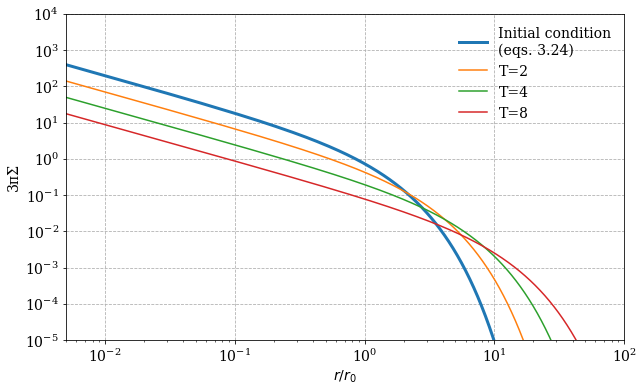

In [5]:
times = [1, 2, 4, 8]
fig, axs = plt.subplots(figsize=(10,6))
plt.grid(ls='--')

axs.loglog(x, (3 * np.pi)**1 * Σ_initial_norm(x), label='Initial condition\n(eqs. 3.24)', lw=3)

for T in times[1:]:
    axs.loglog(x, (3 * np.pi)**1 * Σ(x, T), label=f'T={T}')
plt.legend(frameon = False)

axs.set(xlabel='$r/r_0$', ylabel='3πΣ', ylim = (1e-5, 1e4), xlim = (x_i, x_f), yticks = np.logspace(-5, 4, 10), xticks = np.logspace(-2, 2, 5));

### $\partial_r(\nu\Sigma R^{1/2})$ does not give a unique solution in the boundary - see code below

In [6]:
#for T in times:
for T in times:
    take_dev = Σ(x, T) * x**(3/2)
    first_dev1 = get_first_dev(take_dev, Δx)
    first_dev2 = A @ take_dev

    print(first_dev1[0], first_dev2[0])

1.0126888640715757 1.0126888640715757
0.36319226231755664 0.3631922623175566
0.1293147821038223 0.1293147821038223
0.04587962912154317 0.04587962912154317


## Using analytic solution to generate ghost cell

In [7]:
initial_state = Σ_initial_norm(x)

A = A_matrix_regular(N + 2, 3, 1) / Δx
A[0] = 0
A[0, 0] = 1
A[-1] = 0
A[-1, -1] = 1
sA = csr_matrix(A)

In [8]:
#def anal_bound_ghost(t, Σ):

inner = x**(1) * Σ * x**(1/2)
ghost_1 = np.array([inner[1]])
ghost_2 = np.array([inner[-2]])

inner_ghost = np.concatenate((ghost_1, inner, ghost_2))
x_ghost = np.concatenate((np.array([x[0] - Δx]), x, np.array([x[-1] + Δx])))

outer_ghost = x_ghost**(1/2) * (sA @ inner_ghost) 
sec_dev = 3 / x_ghost * (sA @ outer_ghost)

#return sec_dev[1: -1]

TypeError: unsupported operand type(s) for *: 'float' and 'function'